In [1]:
%reload_ext autoreload

%autoreload 2
import video_processing as vp
import librain as lb
import fnames
import numpy
from roipoly import RoiPoly 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation
import sys
from joblib import Parallel, delayed, cpu_count
from fastdtw import fastdtw
import time

from scipy import signal
import scipy.io as sio
from scipy.ndimage.filters import gaussian_filter
from scipy.spatial.distance import correlation, euclidean #, pdist, canberra
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

import warnings
warnings.filterwarnings('ignore')

In [2]:
HEIGHT = 256
WIDTH = 256
TRUE_FRAMERATE = 28.815
IMAGING_FRAMERATE = 1/(34704.0/1e6)
SIGMA = 2

## File paths

In [60]:
path = "D:/DualMouse/" 

direc = lb.Data(path)

date = "20180312"

experiment = "Experiment_6"

# help(direc.experiment)

EXP_2 = direc.experiment(date, exp_num=6)

# help(direc.file)

timestamps_file = direc.file(
    exp_folder=EXP_2,
    fname="timestamps",
    subfolder="Behaviour",
)

# try: print(fnames.fnames.get("timestamps")) to see an example of a file that would correspond to fname="timestamps" in direc.file

video_file = direc.file(
    exp_folder=EXP_2, 
    fname="h264", 
    subfolder="Behaviour"
)

subset_behaviour_file = direc.file(
    exp_folder=EXP_2,
    fname="interpolated",
    subfolder="Behaviour"
)

l_mouse_processed_file = direc.file(
    exp_folder=EXP_2, 
    fname="left green 0.01-12.0Hz",
    subfolder="Derivatives"
)

r_mouse_processed_file = direc.file(
    exp_folder=EXP_2, 
    fname="right green 0.01-12.0Hz"
)

l_mouse_green_frame_file = direc.file(
    exp_folder=EXP_2, 
    fname="left green",
    subfolder="Derivatives"
)

r_mouse_green_frame_file = direc.file(
    exp_folder=EXP_2, 
    fname="right green",
    subfolder="Derivatives"
)


res = lb.Output(EXP_2) # root directory where processed files will be saved

# help(res.saveas)


### Load Calcium Imaging and Gaussian Filter !!! Original implementation does not make sense

In [61]:
l_green_frame = vp.downsample(
    numpy.load(l_mouse_green_frame_file), (64, 64)
)
r_green_frame = vp.downsample(
    numpy.load(r_mouse_green_frame_file), (64, 64)
)

In [62]:
print(l_mouse_processed_file)

D:\DualMouse\20180312\Experiment_6\Derivatives\LEFT_GREEN_processed__interp_dff0_bandpass0.01-12.0Hz_MM803L_March-12_1633_experiment-6_M802R_wt_cage-mates_mouse_rail_together_12mm.raw


In [63]:
# Separated mice loading
l_mouse_frames = vp.extract_RAW_frames(
    l_mouse_processed_file,
    WIDTH,
    HEIGHT,
    num_channels=1,
    dtype='float32'
)
l_mouse_frames[numpy.where(l_mouse_frames == -numpy.inf)] = -1

r_mouse_frames = vp.extract_RAW_frames(
    r_mouse_processed_file,
    WIDTH,
    HEIGHT,
    num_channels=1,
    dtype='float32'
)
r_mouse_frames[numpy.where(r_mouse_frames==-numpy.inf)] = -1

In [64]:
for i in range(l_mouse_frames.shape[0]):
    l_mouse_frames[i] = gaussian_filter(l_mouse_frames[i], SIGMA)                                      
    r_mouse_frames[i] = gaussian_filter(r_mouse_frames[i], SIGMA)
l_mouse_frames = vp.downsample(l_mouse_frames, (64, 64))
r_mouse_frames = vp.downsample(r_mouse_frames, (64, 64))

### Load behaviour video

In [42]:
behaviour_frames = vp.extract_RAW_frames(
    subset_behaviour_file, 
    320, 
    180, 
    num_channels=1,
    dtype='uint8'
)

In [43]:
print(behaviour_frames.shape)

(10083, 180, 320)


### !!! Todo Mask combined frames

### Mask the individual brains

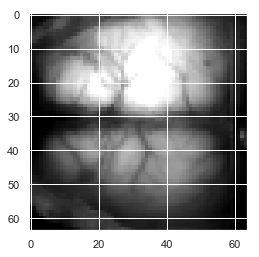

In [202]:
plt.imshow(r_green_frame,cmap='gray', vmin=0, vmax=150)

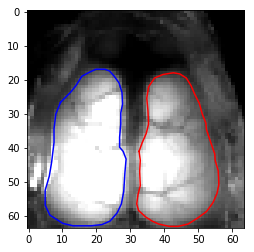

In [13]:
%matplotlib qt
plt.imshow(l_green_frame, cmap='gray', vmin=0, vmax=150)
plt.title('Left mouse left hemisphere')
l_mouse_left_hem = RoiPoly(color='b')

%matplotlib qt
plt.imshow(l_green_frame, cmap='gray', vmin=0, vmax=150)
plt.title('Left mouse right hemisphere')
l_mouse_right_hem = RoiPoly(color='r')

# Let's see what we have
%matplotlib inline
plt.imshow(l_green_frame, cmap='gray', vmin=0, vmax=150)
l_mouse_left_hem.display_roi()
l_mouse_right_hem.display_roi()

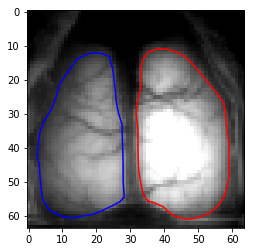

In [14]:
%matplotlib qt
plt.imshow(r_green_frame, cmap='gray', vmin=0, vmax=150)
plt.title('Right mouse left hemisphere')
r_mouse_left_hem = RoiPoly(color='b')

%matplotlib qt
plt.imshow(r_green_frame, cmap='gray', vmin=0, vmax=150)
plt.title('Right mouse right hemisphere')
r_mouse_right_hem = RoiPoly(color='r')

# Let's see what we have
%matplotlib inline
plt.imshow(r_green_frame, cmap='gray', vmin=0, vmax=150)
r_mouse_left_hem.display_roi()
r_mouse_right_hem.display_roi()

### Create and Plot the masks

In [15]:
l_mouse_mask = numpy.logical_or(
    l_mouse_left_hem.get_mask(l_green_frame), 
    l_mouse_right_hem.get_mask(l_green_frame)
)
r_mouse_mask = numpy.logical_or(
    r_mouse_left_hem.get_mask(r_green_frame), 
    r_mouse_right_hem.get_mask(r_green_frame)
)

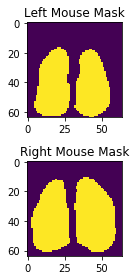

In [16]:
plt.subplot(2, 1, 1)
plt.title("Left Mouse Mask")
plt.imshow(l_mouse_mask)
plt.subplot(2, 1, 2)
plt.title("Right Mouse Mask")
plt.imshow(r_mouse_mask)
plt.tight_layout()

## Save the masks

In [17]:
l_mouse_mask_fname = res.saveas(
    f_out=l_mouse_mask,
    suffix="LM_mask",
    ftype="npy",
    save=True,
)

r_mouse_mask_fname = res.saveas(
    f_out=r_mouse_mask,
    suffix="RM_mask",
    ftype="npy",
    save=True,
)

Saved as LM_mask.npy
Saved as RM_mask.npy


# Load the masks

In [55]:
l_mask_file = direc.file(
    exp_folder=EXP_2, 
    fname='LM mask'
)

r_mask_file = direc.file(
    exp_folder=EXP_2, 
    fname='RM mask'
)

l_mouse_mask = numpy.load(l_mask_file)
r_mouse_mask = numpy.load(r_mask_file)

In [57]:
print(l_mouse_mask.shape)
print(l_mouse_frames.shape)

(64, 64)
(10083, 64, 64)


### Calculate Global signal

In [58]:
l_global_signal, l_mean_g, l_beta_g = vp.global_signal(
    l_mouse_frames[:, l_mouse_mask]
)
r_global_signal, r_mean_g, r_beta_g = vp.global_signal(
    r_mouse_frames[:, r_mouse_mask]
)

l_mouse_frames[:, l_mouse_mask] = (
    l_mouse_frames[:, l_mouse_mask]
    - l_global_signal
)
r_mouse_frames[:, r_mouse_mask] = (
    r_mouse_frames[:, r_mouse_mask]
    - r_global_signal
)


# Save global signals

In [59]:
l_global_signal_fname = res.saveas(
    f_out = l_mean_g,
    suffix = "l_global_signal",
    ftype = "npy",
    dtype = "float32",
    save = True,
)

r_global_signal_fname = res.saveas(
    f_out = r_mean_g,
    suffix = "r_global_signal",
    ftype = "npy",
    dtype = "float32",
    save = True,
)

Saved as l_global_signal.npy
Saved as r_global_signal.npy


In [20]:
print(numpy.shape(r_mean_g))

(10084, 1)


In [21]:
# mask out the untouched values
l_mouse_frames[:, ~l_mouse_mask] = -100
r_mouse_frames[:, ~r_mouse_mask] = -100

## Save the frames

In [22]:
l_mouse_frames_fname = res.saveas(
    f_out=l_mouse_frames,
    suffix="left_mouse_gsr_frames",
    ftype="raw",
    dtype="float32",
    save=True,
)

r_mouse_frames_fname = res.saveas(
    f_out=r_mouse_frames,
    suffix="right_mouse_gsr_frames",
    ftype="raw",
    dtype="float32",
    save=True,
)

Saved as left_mouse_gsr_frames.raw
Saved as right_mouse_gsr_frames.raw


### Replace Combined by the Global signal of the mice

In [214]:
l_mouse_frames[:, l_mouse_mask] = l_global_signal
r_mouse_frames[:, r_mouse_mask] = r_global_signal

combined_frames = numpy.zeros(
    (l_mouse_frames.shape[0], 64, 128)
)
combined_frames[:, :, :64] = l_mouse_frames
combined_frames[:, :, 64:] = r_mouse_frames

combined_frames_fname = res.saveas(
    f_out=combined_frames,
    suffix='gsr_testing',
    ftype='raw',
    save=True,
)

Saved as gsr_testing.raw


### Plot the temporal global mean across space

In [68]:
# l_global_signal = l_mean_g-l_mean_g2
# r_global_signal = r_mean_g-r_mean_g2

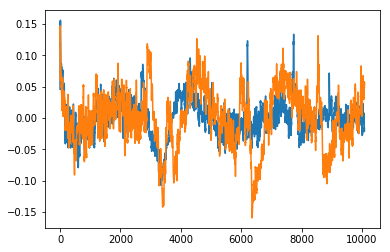

In [23]:
plt.figure()
plt.plot(l_mean_g[:, 0]) # temporal mean across index [:,0,0]
plt.plot(r_mean_g[:, 0]) # temporal mean across index [:,0,0]

# plt.plot(r_mean_g[:, 0])
# plt.figure()
# plt.plot(numpy.mean(l_global_signal[:, :], axis=1))
# print(l_mean_g.shape)
# print(l_global_signal.shape)

# print(numpy.argmax(r_mean_g))



### Plot spectrogram of the means of the raw frames

Saved as LEFT_GREEN_processed_dff0_bandpass0.01-12.0Hz_MM008L_August-23_1232_experiment-3_M104R_neil_cage-mates_together_6mm_spectogram.png


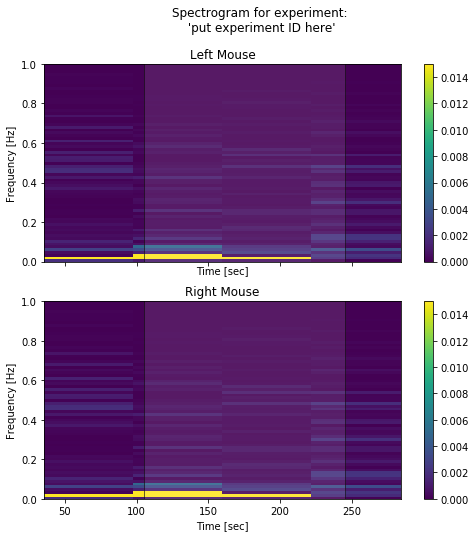

In [25]:
plt.figure(figsize=(8, 8))

# start and stop indices

# indices for later experiments
# start_interaction = numpy.round(numpy.multiply(150, TRUE_FRAMERATE))
# end_interaction = numpy.round(numpy.multiply(150+120, TRUE_FRAMERATE))

# indices for early experiments
start_interaction = numpy.round(numpy.multiply(105, TRUE_FRAMERATE))
end_interaction = numpy.round(numpy.multiply(105+140, TRUE_FRAMERATE))

start_interaction = numpy.round(float(start_interaction)/IMAGING_FRAMERATE, 3)
end_interaction = numpy.round(float(end_interaction)/IMAGING_FRAMERATE, 3)

plt.suptitle("Spectrogram for experiment:\n 'put experiment ID here'")
fs = IMAGING_FRAMERATE

f, t, Sxx = signal.spectrogram(l_mean_g[:, 0], fs, nfft=2048, nperseg=2048)
ax1 = plt.subplot(211)
plt.title("Left Mouse")
plt.pcolormesh(t, f, (Sxx), cmap='viridis', vmin=0.0, vmax=0.015)
plt.axvspan(start_interaction, end_interaction, color='w', alpha=0.1, label='Mice Together')
plt.axvline(start_interaction, color='k', linewidth=1.0, alpha=0.6, label='Mice Together')
plt.axvline(end_interaction, color='k', linewidth=1.0, alpha=0.6, label='Mice Together')
plt.colorbar()
plt.ylim([0, 1])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.setp(ax1.get_xticklabels(), visible=False)


f, t, Sxx = signal.spectrogram(l_mean_g[:, 0], fs, nfft=2048, nperseg=2048)
plt.subplot(212)
plt.title("Right Mouse")
plt.pcolormesh(t, f, (Sxx), cmap='viridis', vmin=0.0, vmax=0.015)
plt.axvspan(start_interaction, end_interaction, color='w', alpha=0.1, label='Mice Together')
plt.axvline(start_interaction, color='k', linewidth=1.0, alpha=0.6, label='Mice Together')
plt.axvline(end_interaction, color='k', linewidth=1.0, alpha=0.6, label='Mice Together')
plt.colorbar()
plt.ylim([0, 1])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

spectogram = res.saveas(
    f_out=plt,
    suffix='spectogram',
    ftype='png',
    f_in=l_mouse_processed_file,
    save=True,
    fig=True,
)

# Plot bandpass filtered global temporal signal and correlation

Saved as LEFT_GREEN_processed_dff0_bandpass0.01-12.0Hz_MM008L_August-23_1232_experiment-3_M104R_neil_cage-mates_together_6mm_correlation_plot.png


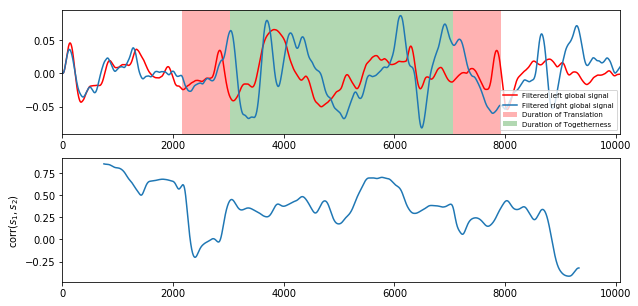

In [31]:
plt.figure(figsize = (10,5))

order = 3
fs = IMAGING_FRAMERATE
cutoff_low = 0.01
cutoff_high = 0.1


def butter_bandpass(cutoff_low, cutoff_high, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff_low = cutoff_low / nyq
    normal_cutoff_high = cutoff_high / nyq
    Wn = [normal_cutoff_low, normal_cutoff_high]
    b, a = signal.butter(
        order, Wn, btype="bandpass", analog=False
    )
    return b, a


def butter_bandpass_filter(
    data, cutoff_low, cutoff_high, fs, order=5
):
    b, a = butter_bandpass(
        cutoff_low, cutoff_high, fs, order=order
    )
    y = signal.lfilter(b, a, data)
    return y


s1 = butter_bandpass_filter(
    numpy.mean(l_global_signal[:, :], axis=1),
    cutoff_low,
    cutoff_high,
    fs,
    order,
)
s2 = butter_bandpass_filter(
    numpy.mean(r_global_signal[:, :], axis=1),
    cutoff_low,
    cutoff_high,
    fs,
    order,
)

# Later experiments
# together_duration = 120
# translation_duration = 24
# first_translation = 126

# start_first_translation = numpy.round(numpy.multiply(first_translation, TRUE_FRAMERATE))
# end_first_translation = numpy.round(numpy.multiply(first_translation + translation_duration, TRUE_FRAMERATE))

# start_interaction = numpy.round(numpy.multiply(first_translation + translation_duration, TRUE_FRAMERATE))
# end_interaction = numpy.round(numpy.multiply(first_translation + translation_duration+together_duration, TRUE_FRAMERATE))

# start_second_translation = numpy.round(numpy.multiply(first_translation + translation_duration+together_duration, TRUE_FRAMERATE))
# end_second_translation = numpy.round(numpy.multiply(first_translation + translation_duration+together_duration+translation_duration, TRUE_FRAMERATE))

# Early experiments
together_duration = 140
translation_duration = 30
first_translation = 75

start_first_translation = numpy.round(numpy.multiply(first_translation, TRUE_FRAMERATE))
end_first_translation = numpy.round(numpy.multiply(first_translation + translation_duration, TRUE_FRAMERATE))

start_interaction = numpy.round(numpy.multiply(first_translation + translation_duration, TRUE_FRAMERATE))
end_interaction = numpy.round(numpy.multiply(first_translation + translation_duration+together_duration, TRUE_FRAMERATE))

start_second_translation = numpy.round(numpy.multiply(first_translation + translation_duration+together_duration, TRUE_FRAMERATE))
end_second_translation = numpy.round(numpy.multiply(first_translation + translation_duration+together_duration+translation_duration, TRUE_FRAMERATE))


window_size = 1500
corrs = []
for i in range(len(s1) - window_size):
    corrs.append(
        1
        - correlation(
            s1[i : i + window_size], s2[i : i + window_size]
        )
    )

plt.subplot(211)
plt.plot(s1, "r", label="Filtered left global signal")
plt.plot(s2, label="Filtered right global signal")

plt.axvspan(
    start_first_translation,
    end_first_translation,
    facecolor="r",
    alpha=0.3,
    label="Duration of Translation",
)
plt.axvspan(
    start_second_translation,
    end_second_translation,
    facecolor="r",
    alpha=0.3,
    #label="Duration of Translation",
)
plt.axvspan(
    start_interaction,
    end_interaction,
    facecolor="g",
    alpha=0.3,
    label="Duration of Togetherness",
)
plt.xlim(0, len(s1))


plt.legend(loc=4, prop={'size': 7})

plt.subplot(212)
lol = 200
corr_x_axis = numpy.linspace(
    window_size / 2, len(s1) - window_size / 2, len(corrs)
)
#corrs = running_mean(corrs, lol)
plt.plot(corr_x_axis, corrs)
plt.ylabel('corr($s_1,s_2$)')
plt.xlim([0, len(s1)])

correlation_plot = res.saveas(
    f_out=plt,
    suffix='correlation_plot',
    ftype='png',
    f_in=l_mouse_processed_file,
    save=True,
    fig=True,
)

### Plot the global signals to show synchronisation

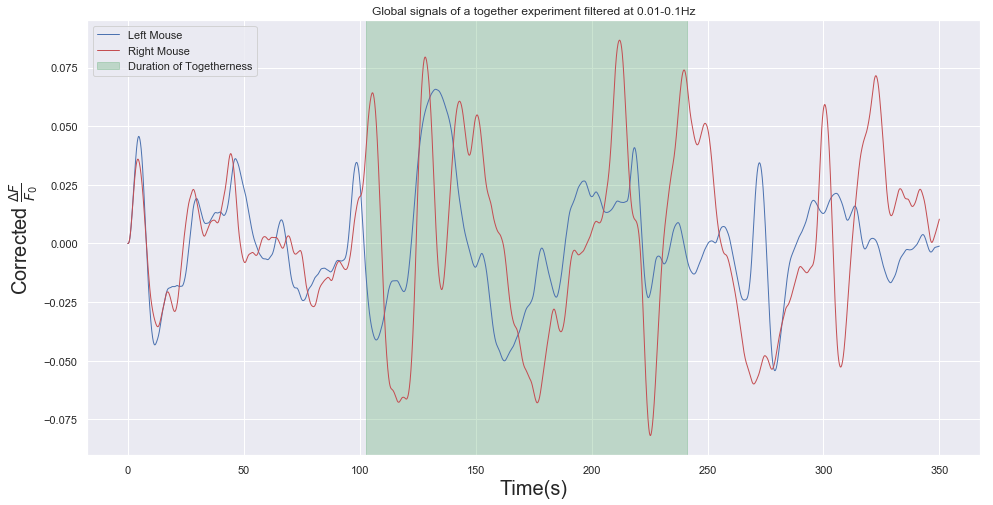

In [32]:
sns.set()
exp_duration = len(s1) / IMAGING_FRAMERATE
time_axis = numpy.linspace(0, exp_duration, len(s1))
start_interaction = 2962 / IMAGING_FRAMERATE
end_interaction = 6950 / IMAGING_FRAMERATE
plt.figure(figsize=(16, 8))
plt.title(
    "Global signals of a together experiment filtered at %s-%sHz"
    % (str(cutoff_low), str(cutoff_high))
)
plt.plot(
    time_axis,
    s1,
    linewidth=1.0,
    color="b",
    label="Left Mouse",
)
plt.plot(
    time_axis,
    s2,
    linewidth=1.0,
    color="r",
    label="Right Mouse",
)
plt.axvspan(
    start_interaction,
    end_interaction,
    color="g",
    alpha=0.3,
    label="Duration of Togetherness",
)
plt.ylabel(r"Corrected $\frac{\Delta F}{F_0}$", size=20)
plt.xlabel("Time(s)", size=20)
plt.legend()

# Plot correlations between bandpass filtered mean signals signals at different frequency bands

In [33]:
frequency_bands = (
    0.01,
    0.1,
    0.5,
    1.0,
    2.0,
    3.0,
    4.0,
    6.0,
    8.0,
    10.0,
    12.0,
)

# 30s sliding window correlation
window_size = 800 #numpy.round(nup.multiply(TRUE_FRAMERATE, 30)) 

fs = IMAGING_FRAMERATE
order = 3
total_bins = l_global_signal.shape[0] - window_size
correlation_image = numpy.zeros(          # Make empty array we will now populate
    (len(frequency_bands) - 1, total_bins)
)
og_s1 = numpy.copy(l_mean_g[:, 0])  # select full temporal means
og_s2 = numpy.copy(r_mean_g[:, 0]) 

frequency_labels = []
for i, (low, high) in enumerate(zip(frequency_bands, frequency_bands[1:])):
    frequency_labels.append(
        str(low) + "-" + str(high) + "Hz"
    )
    s1 = butter_bandpass_filter(
        og_s1, low, high, fs, order
    )
    s2 = butter_bandpass_filter(
        og_s2, low, high, fs, order
    )
    # correlation inside moving window at current frequency band
    for j in range(len(s1) - window_size):
        correlation_image[i, j] = 1 - correlation(
            s1[j : j + window_size], s2[j : j + window_size]
        )

correlation_image_fname = res.saveas(
    f_out=correlation_image,
    suffix='frequency_split_correlation_filtered_ws=800',
    ftype='npy',
    save=True,
)

Saved as frequency_split_correlation_filtered_ws=800.npy


Saved as frequency_split_figure.svg


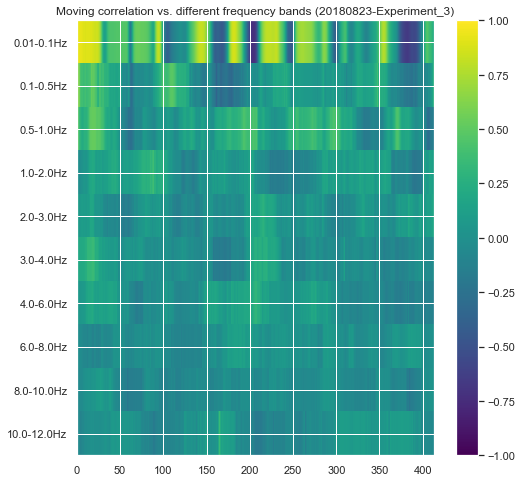

In [34]:
plt.figure(figsize=(8, 8))
plt.title(
    "Moving correlation vs. different frequency bands ({}-{})".format(date, experiment)
)
y_ticks = numpy.arange(correlation_image.shape[0])+0.5
y_ticks = numpy.flipud(y_ticks)
plt.imshow(
    correlation_image, 
    cmap='viridis', 
    extent=[0,413,0,10],
    aspect='auto', 
    vmin=-1, 
    vmax=1
)
plt.yticks(y_ticks, frequency_labels)
plt.colorbar()

frequency_split_fname = res.saveas(
    f_out=plt,
    suffix='frequency_split_figure',
    ftype='svg',
    save=True,
    fig=True,
)

### Shift and plot signal correlations - shift s2 relative to s1 and see where they correlate the most

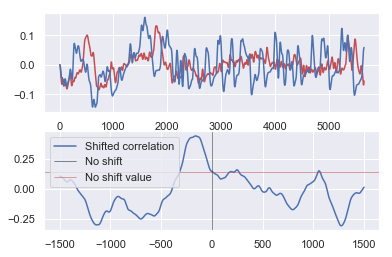

In [76]:
plt.figure()
order=3
fs=IMAGING_FRAMERATE
cutoff=0.5

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

# indices of start and end frames 
interaction_start = 6240
interaction_end = 12853
corrs = []
shift_x = []

og_s1 = butter_lowpass_filter(
    numpy.mean(l_global_signal[interaction_start:interaction_end, :], axis=1), 
    cutoff, 
    fs, 
    order
)
og_s2 = butter_lowpass_filter(
    numpy.mean(r_global_signal[interaction_start:interaction_end, :], axis=1),
    cutoff,
    fs,
    order
)
for i in range(-1500, 1500):
    s1 = numpy.copy(og_s1)
    s2 = numpy.copy(og_s2)

    '''
    Shift one signal over the other
    '''
    if i != 0:
        number_of_frames_to_shift = i
        tmp = numpy.copy(s2[:number_of_frames_to_shift])
        s2[:-number_of_frames_to_shift] = numpy.copy(s2[number_of_frames_to_shift:])
        s2[-number_of_frames_to_shift:] = tmp

    corrs.append(1-correlation(s1, s2))
    shift_x.append(i)
    
shift_x = numpy.asarray(shift_x)
corrs = numpy.asarray(corrs)
    
plt.subplot(211)
plt.plot(og_s1, 'r')
plt.plot(og_s2)
plt.subplot(212)
plt.plot(shift_x, corrs, color='b', label="Shifted correlation")
plt.axvline(0, color='k', linewidth=0.5, label="No shift")
plt.axhline(corrs[numpy.where(shift_x==0)][0], color='r', linewidth=0.5, label="No shift value")
plt.legend()


### Save video with layout:
|   -  |         Col1        |         Col2        |                  Col3                 |
|:----:|:-------------------:|:-------------------:|:-------------------------------------:|
| Row1 |  Left Global Signal | Right Global Signal | Bandpass filtered mean global signals |
| Row2 | Left Calcium Signal | Right Calcium Signal|       Sliding window correlation      |
| Row3 |          -          |      Behaviour      |                   -                   |

Writing frames 94 of 9284

KeyboardInterrupt: 

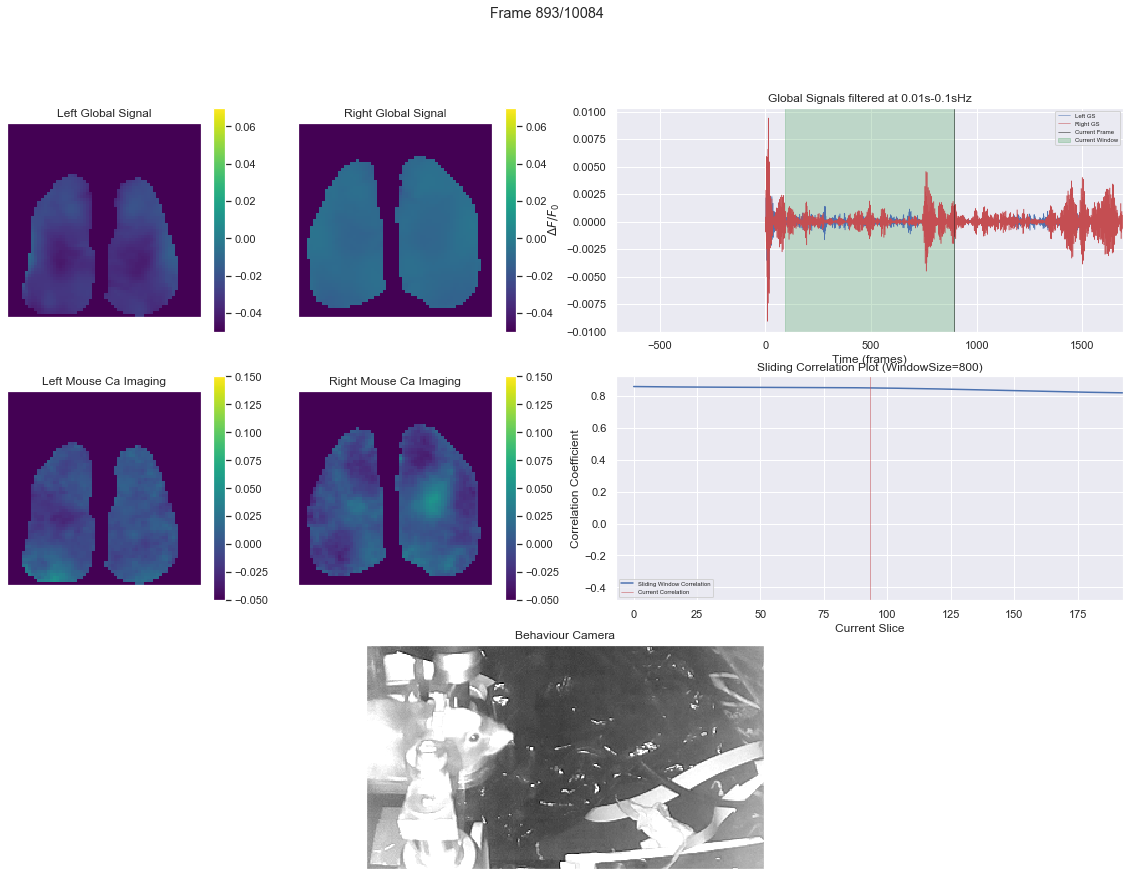

In [35]:
video_frame = numpy.zeros((64, 64))
video_frame[:] = -10
video_frame2 = numpy.zeros((64, 64))
video_frame2[:] = -10

#----------------Configure the writer and canvas----------------#
FFMpegWriter = animation.writers['ffmpeg']
metadata = dict(
    title=EXP_2, artist="Fed", comment="30Hz_playback"
)
writer = FFMpegWriter(fps=30, metadata=metadata)
fig = plt.figure(figsize=(20, 14))

#--------------------Left mouse global signal-------------------#
ax1 = fig.add_subplot(3, 4, 1)
ax1.set_title("Left Global Signal")
ax1.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
video_frame[l_mouse_mask] = l_global_signal[0]
im_map = ax1.imshow(
    video_frame,
    cmap='viridis',
    vmin=-0.05,
    vmax=0.07
)
cbar = fig.colorbar(im_map)

#-------------------Right mouse global signal-------------------#
ax3 = fig.add_subplot(3, 4, 2)
ax3.set_title("Right Global Signal")
ax3.get_yaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
video_frame2[r_mouse_mask] = r_global_signal[0]
im_map_2 = ax3.imshow(
    video_frame,
    cmap='viridis',
    vmin=-0.05,
    vmax=0.07
)
cbar2 = fig.colorbar(im_map_2)

#--------------------Left mouse green frames--------------------#
ax_left_ca = fig.add_subplot(3, 4, 5)
ax_left_ca.set_title("Left Mouse Ca Imaging")
ax_left_ca.get_yaxis().set_visible(False)
ax_left_ca.get_xaxis().set_visible(False)
left_ca_im = ax_left_ca.imshow(
    l_mouse_frames[0],
    cmap='viridis',
    vmin=-0.05,
    vmax=0.15
)
cbar3 = fig.colorbar(left_ca_im)

#-------------------Right mouse green frames--------------------#
ax_right_ca = fig.add_subplot(3, 4, 6)
ax_right_ca.set_title("Right Mouse Ca Imaging")
ax_right_ca.get_yaxis().set_visible(False)
ax_right_ca.get_xaxis().set_visible(False)
right_ca_im = ax_right_ca.imshow(
    r_mouse_frames[0], 
    cmap='viridis', 
    vmin=-0.05, 
    vmax=0.15
)
cbar4 = fig.colorbar(right_ca_im)

#--------------Bandpass filtered mean global signals------------#
ax_global_signal = fig.add_subplot(3, 2, 2)
ax_global_signal.set_title("Global Signals filtered at {}s-{}sHz"
                           .format(str(cutoff_low), 
                                   str(cutoff_high)))
ax_global_signal.set_ylabel(r'$\Delta F/F_0$')
ax_global_signal.set_xlabel('Time (frames)')
left_gs_plot = ax_global_signal.plot(
    s1, 
    color='b', 
    linewidth=0.5, 
    label="Left GS"
)
right_gs_plot = ax_global_signal.plot(
    s2, 
    color='r', 
    linewidth=0.5, 
    label="Right GS"
)
window_span = ax_global_signal.axvspan(
    0, 
    window_size, 
    alpha=0.3, 
    color='g', 
    label='Current Window'
)
now_line = ax_global_signal.axvline(
    window_size, 
    color='k', 
    linewidth=0.5, 
    label='Current Frame'
)
ax_global_signal.legend(prop={'size': 6})

#------------------Sliding window correlation-------------------#
ax_corrs = fig.add_subplot(3, 2, 4)
ax_corrs.set_title("Sliding Correlation Plot (WindowSize={})"
                   .format(str(window_size)))
ax_corrs.set_ylabel("Correlation Coefficient")
ax_corrs.set_xlabel("Current Slice")
corrs_plot = ax_corrs.plot(
    corrs,
    color='b',
    label='Sliding Window Correlation'
)
now_line_corr = ax_corrs.axvline(
    window_size, 
    color='r', 
    linewidth=0.5, 
    label='Current Correlation'
)
ax_corrs.legend(prop={'size': 6})

#---------------------Mouse Behaviour Frame---------------------#
ax2 = fig.add_subplot(3, 1, 3)
ax2.set_title("Behaviour Camera")
ax2.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
behaviour_im = ax2.imshow(
    behaviour_frames[0], 
    cmap='gray', 
    vmin=0, 
    vmax=180
)

with writer.saving(
    fig=fig,
    outfile=EXP_2 + "\\" + "G_FRAMES_separate_low_clim.mp4", 
    dpi=100,
):
    frames = l_global_signal[window_size:]
    n_frames = len(frames)
    for i, frame in enumerate(frames):
        #------------Update stdout stream to show progress------------#
        sys.stdout.write("\r")
        sys.stdout.write(f"Writing frames {i+1} of {n_frames}")
        sys.stdout.flush()
        #----------------------Update Main Title----------------------#
        plt.suptitle(
            "Frame {}/{}"
            .format(str(i+window_size), str(l_global_signal.shape[0]))
        )
        #--------------------Left mouse global signal-------------------#
        video_frame[l_mouse_mask] = l_global_signal[i+window_size]
        im_map.set_data(video_frame)
        #-------------------Right mouse global signal-------------------#
        video_frame2[r_mouse_mask] = r_global_signal[i+window_size]
        im_map_2.set_data(video_frame2)
        #--------------------Left mouse green frames--------------------#
        frame = numpy.copy(l_mouse_frames[i+window_size])
        frame[~l_mouse_mask] = -10
        left_ca_im.set_data(frame)
        #-------------------Right mouse green frames--------------------#
        frame = numpy.copy(r_mouse_frames[i+window_size])
        frame[~r_mouse_mask] = -10
        right_ca_im.set_data(frame)
        #--------------Bandpass filtered mean global signals------------#
        window_span.remove()
        now_line.remove()
        window_span = ax_global_signal.axvspan(
            i, 
            i+window_size, 
            alpha=0.3, 
            color='g', 
            label='Current Correlation Window'
        )
        now_line = ax_global_signal.axvline(
            i+window_size, 
            color='k', 
            linewidth=0.5, 
            label='Current Frame'
        )
        ax_global_signal.set_xlim(
            i-window_size, 
            min(i+2*window_size, 
                l_global_signal.shape[0])
        )
        #------------------Sliding window correlation-------------------#
        ax_corrs.set_xlim(i-100, min(i+100, len(corrs)))
        now_line_corr.remove()
        now_line_corr = ax_corrs.axvline(
            i, 
            color='r', 
            linewidth=0.5, 
            label='Current Correlation'
        )
        plt.draw()
        #---------------------Mouse Behaviour Frame---------------------#
        behaviour_im.set_data(behaviour_frames[i+window_size])
        writer.grab_frame()

### Save video with layout:
|   -  |         Col1         |                  Col2                 |
|:----:|:--------------------:|:-------------------------------------:|
| Row1 |  Left Global Signal  | Bandpass filtered mean global signals |
| Row2 | Right Calcium Signal |       Sliding window correlation      |
| Row3 |       Behaviour      |                   -                   |

Writing frames 9084 of 9084

IndexError: index 10083 is out of bounds for axis 0 with size 10083

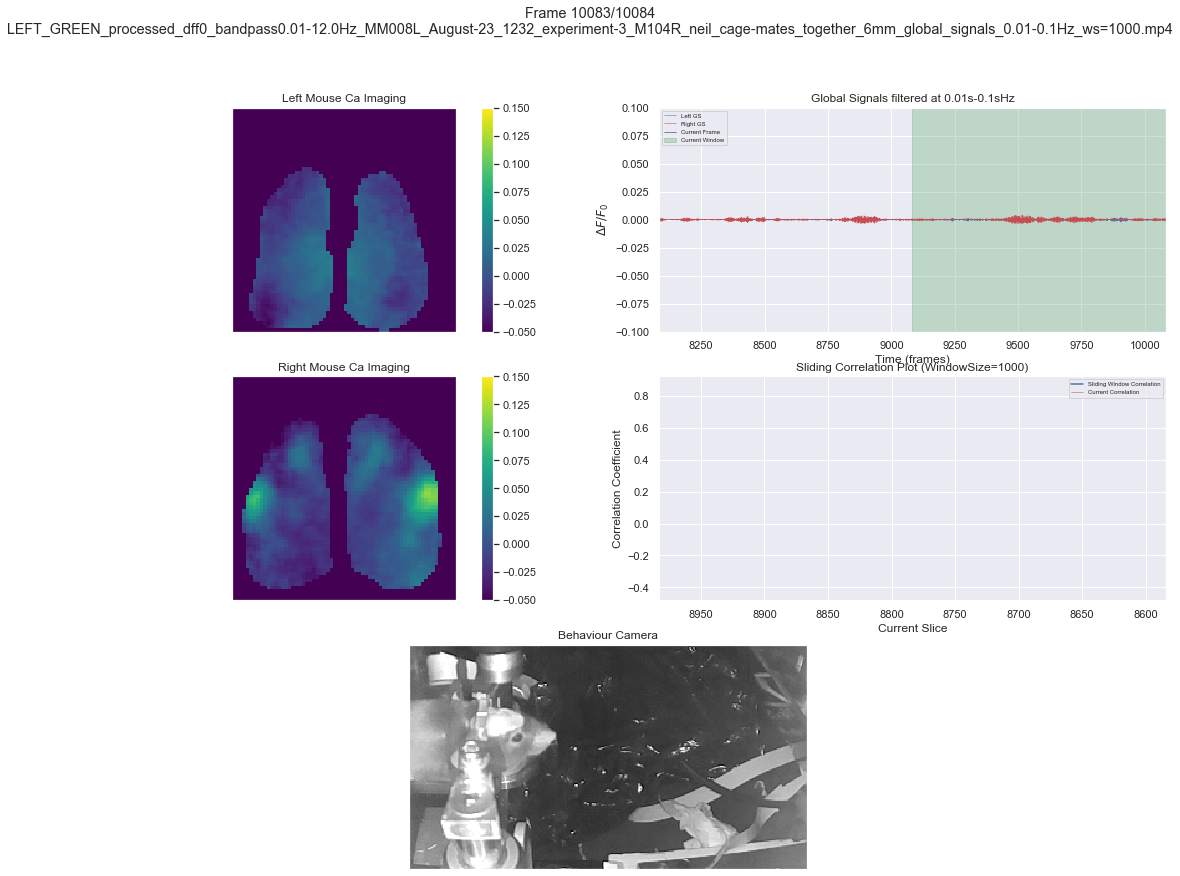

In [36]:
window_size = 1000 # correlation window


# Just the global signals, calcium and behaviour
video_frame = numpy.zeros((64, 64))
video_frame[:] = -10
video_frame2 = numpy.zeros((64, 64))
video_frame2[:] = -10

# Note that the original name of the video looks something like:

# 'LEFT_corrected_g_by_b_processed......12mm_global_signals_filtered_at_0.01-0.1Hz_window_correlation_ws=3800.mp4'

# This file name is too long for Windows to save so it's shortened to:

# 'LEFT_corrected_g_by_b_processed......12mm_global_signals_0.01-0.1Hz_ws=3800.mp4'

# Generate file name for video; create placeholder array - f_out cannot be empty 
global_sig_fname = res.saveas(
    f_out=numpy.array(["placeholder"]),
    suffix='global_signals_{}-{}Hz_ws={}'.format(
        str(cutoff_low), str(cutoff_high), str(window_size)
    ),
    ftype='mp4',
    f_in=l_mouse_processed_file,
)

#----------------Configure the writer and canvas----------------#
FFMpegWriter = animation.writers['ffmpeg']
metadata = dict(
    title=EXP_2, artist="Fed", comment="30Hz_playback"
)
writer = FFMpegWriter(fps=30, metadata=metadata, bitrate=2000)
fig = plt.figure(figsize=(20, 14))

#--------------------Left mouse green frames--------------------#
ax_left_ca = fig.add_subplot(3, 2, 1)
ax_left_ca.set_title("Left Mouse Ca Imaging")
ax_left_ca.get_yaxis().set_visible(False)
ax_left_ca.get_xaxis().set_visible(False)
left_ca_im = ax_left_ca.imshow(
    l_mouse_frames[0], 
    cmap='viridis', 
    vmin=-0.05, 
    vmax=0.15
)
cbar3 = fig.colorbar(left_ca_im)
#-------------------Right mouse green frames--------------------#
ax_right_ca = fig.add_subplot(3, 2, 3)
ax_right_ca.set_title("Right Mouse Ca Imaging")
ax_right_ca.get_yaxis().set_visible(False)
ax_right_ca.get_xaxis().set_visible(False)
right_ca_im = ax_right_ca.imshow(
    r_mouse_frames[0], 
    cmap='viridis', 
    vmin=-0.05, 
    vmax=0.15
)
cbar4 = fig.colorbar(right_ca_im)
#--------------Bandpass filtered mean global signals------------#
ax_global_signal = fig.add_subplot(3, 2, 2)
ax_global_signal.set_title("Global Signals filtered at {}s-{}sHz"
                           .format(str(cutoff_low), 
                                    str(cutoff_high)))
ax_global_signal.set_ylabel(r'$\Delta F/F_0$')
ax_global_signal.set_xlabel('Time (frames)')
left_gs_plot = ax_global_signal.plot(
    s1, 
    color='b', 
    linewidth=0.5, 
    label="Left GS"
)
right_gs_plot = ax_global_signal.plot(
    s2, 
    color='r', 
    linewidth=0.5, 
    label="Right GS"
)
window_span = ax_global_signal.axvspan(
    0, 
    window_size, 
    alpha=0.3, 
    color='g', 
    label='Current Window'
)
now_line = ax_global_signal.axvline(
    window_size, 
    color='k', 
    linewidth=0.5, 
    label='Current Frame'
)
ax_global_signal.legend(prop={'size': 6})
#------------------Sliding window correlation-------------------#
ax_corrs = fig.add_subplot(3, 2, 4)
ax_corrs.set_title("Sliding Correlation Plot (WindowSize={})"
                   .format(str(window_size)))
ax_corrs.set_ylabel("Correlation Coefficient")
ax_corrs.set_xlabel("Current Slice")
corrs_plot = ax_corrs.plot(
    corrs, 
    color='b', 
    label='Sliding Window Correlation'
)
now_line_corr = ax_corrs.axvline(
    window_size, 
    color='r', 
    linewidth=0.5, 
    label='Current Correlation'
)
ax_corrs.legend(prop={'size': 6})
#---------------------Mouse Behaviour Frame---------------------#
ax2 = fig.add_subplot(3, 1, 3)
ax2.set_title("Behaviour Camera")
ax2.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
behaviour_im = ax2.imshow(
    behaviour_frames[0], 
    cmap='gray', 
    vmin=0, 
    vmax=255
)

with writer.saving(
    fig, outfile=EXP_2 + "\\" + global_sig_fname, dpi=210
):
    frames = l_global_signal[window_size:]
    n_frames = len(frames)
    for i, frame in enumerate(frames):
        #------------Update stdout stream to show progress------------#
        sys.stdout.write("\r")
        sys.stdout.write(f"Writing frames {i+1} of {n_frames}")
        sys.stdout.flush()
        
        #----------------------Update Main Title----------------------#
        plt.suptitle("Frame {}/{}\n{}" 
                     .format(str(i+window_size), 
                             str(l_global_signal.shape[0]), 
                             global_sig_fname
                             )
                    )
        #--------------------Left mouse green frames--------------------#
        frame = numpy.copy(l_mouse_frames[i+window_size])
        frame[~l_mouse_mask] = -100
        left_ca_im.set_data(frame)
        #-------------------Right mouse green frames--------------------#        
        frame = numpy.copy(r_mouse_frames[i+window_size])
        frame[~r_mouse_mask] = -100
        right_ca_im.set_data(frame)
        #--------------Bandpass filtered mean global signals------------#
        window_span.remove()
        now_line.remove()
        window_span = ax_global_signal.axvspan(
            i, 
            i+window_size, 
            alpha=0.3, 
            color='g',
            label='Current Corr Window'
        )
        now_line = ax_global_signal.axvline(
            i+window_size, 
            color='k', 
            linewidth=0.5, 
            label='Current Frame'
        )
        ax_global_signal.set_xlim(
            i-window_size, 
            min(i+2*window_size, l_global_signal.shape[0])
        )
        valid_slice_start = max(0, i-window_size)
        valid_slice_end = min(len(s1)-1, i+2*window_size)
        y_min_lim = min(-0.1, 
                        numpy.min(s1[valid_slice_start:valid_slice_end]), 
                        numpy.min(s2[valid_slice_start:valid_slice_end]))
        y_max_lim = max(0.1, 
                        numpy.max(s1[valid_slice_start:valid_slice_end]), 
                        numpy.max(s2[valid_slice_start:valid_slice_end]))
        ax_global_signal.set_ylim(y_min_lim, y_max_lim)
        #------------------Sliding window correlation-------------------#
        now_line_corr.remove()
        now_line_corr = ax_corrs.axvline(i, 
                                         color='r', 
                                         linewidth=0.5, 
                                         label='Current Correlation')
        ax_corrs.set_xlim(i-100, min(i+100, len(corrs)))
        plt.draw()
        #---------------------Mouse Behaviour Frame---------------------#
        behaviour_im.set_data(behaviour_frames[i+window_size])
        writer.grab_frame()

In [87]:
i=100
valid_slice_start = max(0, i-window_size)
valid_slice_end = min(len(s1)-1, i+2*window_size)
print(valid_slice_start)
print(valid_slice_end)
print(s1.shape)

0
2100
(12028,)


### Stitch left and right masks together

In [ ]:
all_masks = numpy.zeros((64, 128), dtype=numpy.bool)
all_masks[:, :64] = l_mouse_mask
all_masks[:, 64:] = r_mouse_mask

## ??

In [ ]:
def calculate_correlation_map_of_slice(slice_frames, seed):
    slice_map = numpy.zeros((slice_frames.shape[1]))
    for i in range(slice_frames.shape[1]):
        slice_map[i] = correlation(slice_frames[:, i], seed)
    return slice_map

def calculate_correlation_map(FRAMES, seed, n_jobs=1):
    if n_jobs < 0:
        n_jobs = max(8 + 1 + n_jobs, 1)
        
    fd = delayed(calculate_correlation_map_of_slice)
    ret = Parallel(n_jobs=n_jobs, verbose=0)(
        fd(FRAMES[:, s], seed)
        for s in vp.gen_even_slices(FRAMES.shape[1], n_jobs))

    return numpy.hstack(ret) 

In [ ]:
spcm = numpy.zeros((64, 128))
masked_spcm = calculate_correlation_map(
    combined_frames[:,all_masks],
    combined_frames[:, 43, 72],
    -1
)
spcm[all_masks] = 1-masked_spcm
plt.imshow(spcm,vmin=0, vmax=1)

### Euclidean Distances for entire dataset

In [ ]:
metric = euclidean

def calculate_pairwise_distances_video(FRAMES, all_masks, metric=metric):
    total_seeds = numpy.zeros_like(all_masks)[all_masks].shape[0]
    masked_frames = FRAMES[:, all_masks]
    distance_array = pairwise_distances(
        masked_frames.T,
        metric=metric, 
        n_jobs=-1 # Using all processors
    )
    
    return distance_array

In [ ]:
# This is very cpu intensive and takes a while ~5min to process.
full_distance_array = calculate_pairwise_distances_video(combined_frames, all_masks)

### Generate video of all seed maps

In [ ]:
seed_map = numpy.zeros((64, 128))
seed_map[:] = -10

# Generate file name for video; create placeholder array - f_out cannot be empty 
seed_fname = res.saveas(
    f_out=numpy.array(["placeholder"]),
    suffix="all_seed_maps_metric-{}".format(
        metric.__name__
    ),
    ftype="mp4",
    f_in=video_file,
)

FFMpegWriter = animation.writers['ffmpeg']
metadata = dict(
    title=EXP_2, artist="Fed", comment="10Hz_playback"
)
writer = FFMpegWriter(fps=10, metadata=metadata)
fig = plt.figure(figsize=(10, 8))

ax1 = fig.add_subplot(1, 1, 1)
ax1.set_title("All the seed maps")
ax1.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
seed_map[all_masks] = full_distance_array[0]
im_map = ax1.imshow(seed_map, 
                    cmap='viridis', 
                    vmin=0, 
                    vmax=1)
cbar = plt.colorbar(im_map)

with writer.saving(
    fig, outfile=EXP_2 + "\\" + seed_fname, dpi=100
):
    #------------Update stdout stream to show progress------------#
    n_frames = full_distance_array.shape[0]
    for i, combined_frame in enumerate(full_distance_array, start=1):
        sys.stdout.write("\r")
        sys.stdout.write(f"Writing frames {i} of {n_frames}")
        sys.stdout.flush()
        ax1.set_title("Seed Map {}/{}"
                      .format(str(i), 
                              str(full_distance_array.shape[0])))
        seed_map[all_masks] = 1-full_distance_array[i-1]
        im_map.set_data(seed_map)
        writer.grab_frame()

## Cluster the entire dataset

In [ ]:
a = time.time()
window_shift = 120 # how many frames to move each time
window_size = 2800 # size of the window
metric = euclidean


total_seeds = numpy.zeros_like(all_masks)[all_masks].shape[0]
n_windows = int((combined_frames.shape[0]-window_size)/window_shift)+1
windowed_distance_array = numpy.zeros(
    (n_windows, # how many of these windows we have
     total_seeds, 
     total_seeds)
)
times = []
for i in range(n_windows):
    windowed_distance_array[i] = calculate_pairwise_distances_video(
        combined_frames[i*window_shift:i*window_shift+window_size], 
        all_masks, 
        metric=metric
    )
    times.append(time.time()-a)
    sys.stdout.write("\r")
    sys.stdout.write(f"Processed frames {i+1} of {n_windows}")
    sys.stdout.flush()

In [ ]:
test = sio.loadmat('/media/gu4n1n3/Data3/con_mouse33.mat')

In [ ]:
plt.figure()
test[all_masks] = windowed_distance_array[0, 2000, 0]
plt.imshow(test)

In [ ]:
cluster_maps = numpy.zeros((windowed_distance_array.shape[0], 64, 128))
n_clusters = 10
previous_centers = None
for d, distance_array in enumerate(windowed_distance_array):
    model = KMeans(
        n_clusters = n_clusters, 
        init='k-means++', 
        n_init=10, 
        precompute_distances=True,
        n_jobs=-1
    )
    model.fit(distance_array)
    if d!=0:
        center_dist = pairwise_distances(
            previous_centers, 
            model.cluster_centers_, 
            metric=euclidean
        )
        argmins = numpy.argmin(center_dist, axis=1)
        for i in range(argmins.shape[0]):
            temp = numpy.copy(model.cluster_centers_[i, :])
            model.cluster_centers_[i] = model.cluster_centers_[argmins[i]]
            model.cluster_centers_[argmins[i]] = temp
            argmins[numpy.where(argmins==i)] = argmins[i]
            argmins[i] = i

        argmins = numpy.argmin(center_dist, axis=1)
        order_of_swap = numpy.argsort(numpy.min(center_dist, axis=1))

    Z = model.predict(distance_array)`
    Z[numpy.where(Z==0)]=numpy.max(Z)+1
    cluster_maps[d][all_masks] = Z

    assert(numpy.all(numpy.equal(numpy.sort(model.cluster_centers_[:,0]), 
                                 numpy.sort(numpy.unique(model.cluster_centers_[:, 0])))))

    previous_centers = numpy.copy(model.cluster_centers_)

### Make video of cluster maps with the following layout
|   -  |         Col1        |
|:----:|:-------------------:|
| Row1 |   Behaviour Video   |
| Row2 | K-Means Cluster Map |
| Row3 |   Calcium Imaging   |

In [ ]:
FFMpegWriter = animation.writers['ffmpeg']

# Note that the original name of the video looks something like:

# 'GLOBAL_SIGNALS_combined_video_clusters_KMEANS-10-clusters_window-size-2800-frames_metric-euclidean.mp4'

# This file name is too long for Windows to save so it's shortened to:

# 'GLOBAL_SIGNALS_combined_KMEANS-10-clusters_ws=2800_metric-euclidean.mp4'

# Generate file name for video; create placeholder array - f_out cannot be empty 
clusters_fname = res.saveas(
    f_out=numpy.array(["placeholder"]),
    suffix="GLOBAL_SIGNALS_combined_KMEANS-{}-clusters_ws={}_metric-euclidean.mp4".format(
        str(n_clusters), str(window_size), metric.__name__
    ),
    ftype="mp4",
    f_in=video_file,
)

#----------------Set up the writer and the canvas----------------#
metadata = dict(
    title=EXP_2, artist="Fed", comment="30Hz_playback"
)
writer = FFMpegWriter(fps=30, metadata=metadata)
fig = plt.figure(figsize=(8, 10))

#------------------Downsampled Mouse Behaviour-------------------#
ax1 = fig.add_subplot(3, 1, 1)
ax1.set_title("Behaviour Video downsampled to 30Hz from 90Hz")
ax1.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
im_behaviour = ax1.imshow(
    behaviour_frames[0], 
    clim=(0, 255), 
    cmap='gray'
)

#-------------------------Cluster Maps---------------------------#
ax2 = fig.add_subplot(3, 1, 2)
ax2.set_title("Cluster 0/%s from current frame of window size {}"
              .format(str(cluster_maps.shape[0]), str(window_size)))
ax2.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
im_cluster = ax2.imshow(
    cluster_maps[0],
    clim=(0, n_clusters),
    cmap='tab20'
)

#-------------Combined Left and Right Green Frames---------------#
ax3 = fig.add_subplot(3, 1, 3)
ax3.set_title("Calcium Imaging Data playback at 30Hz from 28.815Hz")
ax3.get_yaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
im_plot = ax3.imshow(
    combined_frames[0], 
    clim=(-.05, 0.1), 
    cmap='viridis'
)
cbar = fig.colorbar(im_plot)

with writer.saving(
    fig=fig, outfile=EXP_2 + "\\" + clusters_fname, dpi=100
):
    frames = combined_frames[1:]
    n_frames = len(combined_frames)
    for i, combined_frame in enumerate(frames):
        sys.stdout.write("\r")
        sys.stdout.write(f"Writing frames {i+1} of {n_frames}")
        sys.stdout.flush()
        current_time = numpy.round(float(i)/IMAGING_FRAMERATE, 3)
        current_cluster_count = min((i//window_shift), cluster_maps.shape[0]-1) ## Why -1
        # Set title
        ax2.set_title("Cluster {}/{} from current frame of window size {}" 
                      .format(
                          str(current_cluster_count), 
                          str(cluster_maps.shape[0]), 
                          str(window_size)
                      ))
        plt.suptitle(
            video_file.split("/")[-1]+
            "\n"+
            "Current Frame: "+
            "{:5d}".format(i)+
            " Current Time: "+
            "{:4.3f}"
            .format(current_time)+
            " seconds"
        )
        im_behaviour.set_data(behaviour_frames[i])
        im_cluster.set_data(cluster_maps[current_cluster_count])
        im_plot.set_data(combined_frames[i])
        writer.grab_frame()

### !!! Dissimilarity and time warping of signals 

In [ ]:
def dissim(x,y,beta=0):
    ab = numpy.array([getdxy(x,y,beta),getdxy(y,x,beta)])
    dxy = numpy.min(ab)
    
    return numpy.log(dxy)

def getdxy(x,y,beta):
    M=x.shape[0]
    N=y.shape[0]
    sigma=numpy.std(y)
    phi=beta*4.0*sigma/float(numpy.min((M,N)))
    tx=0
    ty=0
    dxy=0
    while tx<M and ty<N:
        cmin,tx,ty=getcmin(x,tx,y,ty,phi)
        dxy+=cmin
        if tx>=M or ty>=N:
            break
        cmin,tx,ty=getcmin(y,ty,x,tx,phi)
        dxy+=cmin
    return dxy

def getcmin(x,tx,y,ty,phi):
    M=x.shape[0]
    cmin=10**10
    delta=0
    deltamin=0
    while ty+delta<M:
        c=(phi*delta)**2
        if c>cmin:
            if ty+delta>tx: 
                break
            continue
        c+=(x[tx]-y[ty+delta])**2
        if c<cmin:
            cmin=c
            deltamin=delta
        delta+=1
    return cmin,tx+1,ty+deltamin+1

In [ ]:
sig_fig = plt.figure(figsize=(8, 14))
masked_frames = combined_frames[:, all_masks].T
signal_a = signal.savgol_filter(masked_frames[3005, :], 201, 4)
signal_b = signal.savgol_filter(masked_frames[3122, :], 201, 4)


window_shift = 120
window_size = 1200


sig_ax = sig_fig.add_subplot(4, 1, 1)
sig_ax.plot(signal_a, 'r', linewidth=0.5)
sig_ax.plot(signal_b, 'b', linewidth=0.5)
sig_ax.set_title("The two signals")

#Calculate dynamic metrics
dynamic_dtw = numpy.zeros(int((signal_a.shape[0]-window_size)/window_shift)+1)
dynamic_eucl = numpy.zeros(int((signal_a.shape[0]-window_size)/window_shift)+1)
dynamic_corr = numpy.zeros(int((signal_a.shape[0]-window_size)/window_shift)+1)
for i in range(int((signal_a.shape[0]-window_size)/window_shift)+1):
    dynamic_corr[i] = dissim(signal_a[i*window_shift:i*window_shift+window_size], 
                                signal_b[i*window_shift:i*window_shift+window_size], 0)
    
coeff1 = dynamic_eucl[numpy.argmin(dynamic_dtw)]/numpy.min(dynamic_dtw)
coeff2 = dynamic_corr[numpy.argmin(dynamic_dtw)]/numpy.min(dynamic_dtw)
all_ax = sig_fig.add_subplot(4, 1, 2)
all_ax.set_title("All the measures together")
all_ax.plot(dynamic_dtw, linewidth=0.5, color='r', label="DTW")
all_ax.plot(dynamic_eucl, linewidth=0.5, color='k', label="Euclidean")
all_ax.plot(dynamic_corr, linewidth=0.5, color='b', label="MJC")
plt.legend()

eucl_ax = sig_fig.add_subplot(4, 1, 3)
eucl_ax.plot(dynamic_eucl, linewidth=0.5, color='k', label="Raw Euclidean")
plt.legend()

corr_ax = sig_fig.add_subplot(4, 1, 4)
corr_ax.plot(dynamic_corr, linewidth=0.5, color='k', label="Raw MJC")
plt.legend()

### Use Dynamic Time Warping algorithm to find the approximate distance between 2 time series

In [ ]:
print(fastdtw.__doc__)

In [ ]:
distance, path = fastdtw(signal_a, signal_b, dist=euclidean)

### Compare the synchronisation of the two signals

In [ ]:
plt.plot(signal_a)
plt.plot(signal_b)

In [ ]:
plt.plot(signal_a[numpy.asarray(path)[:,0]])
plt.plot(signal_b[numpy.asarray(path)[:,1]])